In [24]:
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime, dateutil

%matplotlib inline

# DEAD ANIMALS

In [25]:
train = pd.read_csv('train.csv')
display(train.dtypes)
display(train.head())
display(train.describe())

AnimalID          object
Name              object
DateTime          object
OutcomeType       object
OutcomeSubtype    object
AnimalType        object
SexuponOutcome    object
AgeuponOutcome    object
Breed             object
Color             object
dtype: object

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A677073,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824


In [26]:
import re
sterilized_pat = re.compile('.*(neutered|spayed).*', flags=re.IGNORECASE)

def purify_age(df):
    days_in_unit = {
    'day': 1,
    'days': 1,
    'week': 7,
    'weeks': 7,
    'month': 30,
    'months': 30,
    'years': 365,
    'year': 365
    }
    
    def strage_to_days(age):
        if not isinstance(age, str): return float('nan')
        age = age.split(' ')
        return int(age[0]) * days_in_unit[age[1]]
    df['AgeuponOutcome'] = df['AgeuponOutcome'].map(strage_to_days)

def purify_sex(df):
    df['Sterilized'] = df.SexuponOutcome.str.match(sterilized_pat)
    df.loc[df['Sterilized'].isnull(), 'Sterilized'] = 2
    df['Sterilized'] = df['Sterilized'].astype('int')
    def shorten_sex(sex):
        if isinstance(sex, str):
            if 'Male' in sex:
                return 0
            elif 'Female' in sex:
                return 1
        return 2 # the Unknown
    df['SexuponOutcome'] = df['SexuponOutcome'].map(shorten_sex).astype('int')

import datetime

def datetime_purify(df):
    def transform_date(date):
        date = dateutil.parser.parse(date)
        date = datetime.datetime(year=date.year, month=date.month, day=date.day)
        return date
    df.DateTime = df.DateTime.apply(transform_date)
    
def purify_1(df):
    df = df.drop(['ID', 'AnimalID'], axis=1, errors='ignore')
    df['Name'] = pd.notnull(df['Name'])
    df['Mix'] = df.Breed.str.match(re.compile('.*(Mix|/)')).astype('int')
    df['Breed'] = df.Breed.str.rstrip(' Mix')
    df['Multicolor'] = df.Color.str.contains('/')
    df.loc[df['Color'].str.match(
        re.compile('.*(multi|poly|parti|point|calico).*',
                   flags=re.IGNORECASE)), 'Multicolor'] = 1
    purify_age(df)
    purify_sex(df)
    datetime_purify(df)
    return df

applied_transforms = [purify_1]

In [27]:
X = purify_1(train)
X.head()

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Mix,Multicolor,Sterilized
0,True,2014-02-12,Return_to_owner,NaN,Dog,0,365.0,Shetland Sheepdog,Brown/White,1,True,1
1,True,2013-10-13,Euthanasia,Suffering,Cat,1,365.0,Domestic Shorthair,Cream Tabby,1,False,1
2,True,2015-01-31,Adoption,Foster,Dog,0,730.0,Pit Bull,Blue/White,1,True,1
3,False,2014-07-11,Transfer,Partner,Cat,0,21.0,Domestic Shorthair,Blue Cream,1,False,0
4,False,2013-11-15,Transfer,Partner,Dog,0,730.0,Lhasa Apso/Miniature Poodle,Tan,1,False,1


In [28]:
df = X[['Breed', 'AgeuponOutcome']].groupby('Breed').describe()
df[df['AgeuponOutcome', 'count'] > 100]

AgeuponOutcome                                  \
                                        count         mean          std   min   
Breed                                                                           
American Bulldog                        115.0   866.478261   718.065436   5.0   
American Staffordshire Terrier          104.0   941.625000   854.172673   2.0   
Australian Cattle Dog                   392.0   890.272959  1127.644638   7.0   
Australian Kelpie                       101.0   478.960396   632.389878  21.0   
Australian Shepherd                     177.0  1095.553672  1282.903777  28.0   
Beagle                                  146.0  1582.910959  1394.064110  30.0   
Border Collie                           246.0   993.321138  1270.271987  14.0   
Boxer                                   275.0  1048.909091  1106.237248  30.0   
Cairn Terrier                           112.0   685.982143   714.100846  30.0   
Catahoula                               163.0   790.214724   991.254092  30.0   
Chihuahua Longhair                      151.0  1019.960265  1050.491142   6.0   
Chihuahua Shorthair                    1851.0  1078.337115  1178.801408   4.0   
Dachshund                               364.0  1181.478022  1231.437592   2.0   
Domestic Longhair                       542.0  1021.911439  1417.130079   0.0   
Domestic Medium Hair                    881.0   530.437003   978.291017   3.0   
Domestic Shorthair                     8937.0   428.381112   844.626310   0.0   
German Shepherd                         652.0   892.253067  1078.210628   2.0   
Jack Russell Terrier                    162.0  1172.580247  1349.304595  28.0   
Labrador Retriever                     1432.0   961.934358  1195.602491   1.0   
Miniature Poodle                        254.0  1358.484252  1295.898579  30.0   
Miniature Schnauzer                     158.0  1411.455696  1316.632491  60.0   
Pit Bull                               1972.0   865.593306   821.283950   1.0   
Rat Terrier                             170.0  1525.105882  1548.908770   6.0   
Rottweiler                              152.0  1194.065789  1071.716088   0.0   
Shih Tzu                                153.0  1534.882353  1297.703285   7.0   
Siamese                                 413.0   695.450363  1172.716271   2.0   
Siberian Husky                          168.0  1081.130952  1078.709129  60.0   
Staffordshire                           102.0   874.460784   645.364624  60.0   
Yorkshire Terrier                       167.0  1438.958084  1392.182063   3.0   

                                                                
                                  25%     50%      75%     max  
Breed                                                           
American Bulldog                365.0   730.0  1095.00  2920.0  
American Staffordshire Terrier  365.0   730.0  1095.00  4015.0  
Australian Cattle Dog           150.0   365.0  1095.00  5840.0  
Australian Kelpie               120.0   330.0   730.00  4015.0  
Australian Shepherd             180.0   730.0  1460.00  6205.0  
Beagle                          365.0  1095.0  2555.00  5475.0  
Border Collie                   150.0   365.0  1095.00  5840.0  
Boxer                           300.0   730.0  1460.00  5110.0  
Cairn Terrier                   232.5   365.0   730.00  3650.0  
Catahoula                       180.0   365.0  1095.00  5110.0  
Chihuahua Longhair              300.0   730.0  1460.00  5475.0  
Chihuahua Shorthair             365.0   730.0  1460.00  6570.0  
Dachshund                       300.0   730.0  1825.00  5840.0  
Domestic Longhair                60.0   365.0  1460.00  6570.0  
Domestic Medium Hair             60.0   120.0   365.00  7300.0  
Domestic Shorthair               30.0    90.0   365.00  7300.0  
German Shepherd                 180.0   365.0  1095.00  5840.0  
Jack Russell Terrier            157.5   730.0  1825.00  5475.0  
Labrador Retriever              120.0   365.0  1460.00  6205.0  
Miniatur

In [29]:
X.isnull().sum()

Name                  0
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        0
AgeuponOutcome       18
Breed                 0
Color                 0
Mix                   0
Multicolor            0
Sterilized            0
dtype: int64

In [30]:
X[['AnimalType', 'Mix', 'AgeuponOutcome']].groupby(['AnimalType', 'Mix']).describe()

AgeuponOutcome                                                \
                        count         mean          std  min    25%     50%   
AnimalType Mix                                                                
Cat        0            253.0   619.209486  1145.915947  2.0   60.0   120.0   
           1          10864.0   493.310659   936.473840  0.0   35.0    90.0   
Dog        0           1138.0  1511.528120  1321.028133  2.0  365.0  1095.0   
           1          14456.0   966.790329  1099.315319  0.0  240.0   730.0   

                                
                   75%     max  
AnimalType Mix                  
Cat        0     730.0  6935.0  
           1     365.0  7300.0  
Dog        0    2190.0  6935.0  
           1    1095.0  6935.0

In [31]:
display(
    X.loc[X['Sterilized'] == 2],
    X.loc[X['Mix'] == 2],
    X.loc[X['SexuponOutcome'] == 2].head(),
    X.loc[X['AgeuponOutcome'].isnull()],
    X.loc[X['AgeuponOutcome'].isnull()].describe())

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Mix,Multicolor,Sterilized
3174,True,2013-11-27,Return_to_owner,NaN,Dog,2,2555.0,Dachshund,Brown Merle,0,False,2


,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Mix,Multicolor,Sterilized


,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Mix,Multicolor,Sterilized
7,False,2015-04-30,Transfer,Partner,Cat,2,21.0,Domestic Shorthair,Brown Tabby,1,False,0
10,False,2013-12-05,Transfer,SCRP,Cat,2,730.0,Domestic Shorthair,Black,1,False,0
64,False,2014-07-17,Transfer,Partner,Cat,2,14.0,Domestic Shorthair,Black,1,False,0
68,False,2015-06-16,Transfer,SCRP,Cat,2,60.0,Domestic Shorthair,Brown Tabby/White,1,True,0
81,False,2015-09-22,Euthanasia,Suffering,Cat,2,14.0,Domestic Shorthair,Blue Tabby,1,False,0


,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Mix,Multicolor,Sterilized
2480,False,2016-02-16,Transfer,SCRP,Cat,0,NaN,Domestic Shorthair,Blue Tabby/White,1,True,0
2912,False,2016-02-18,Transfer,SCRP,Cat,2,NaN,Domestic Shorthair,Gray Tabby,1,False,0
3766,False,2016-02-16,Transfer,SCRP,Cat,1,NaN,Domestic Shorthair,Brown Tabby,1,False,0
3875,False,2016-02-20,Euthanasia,Suffering,Dog,0,NaN,Toy Poodle,White,1,False,0
4498,False,2016-02-09,Transfer,SCRP,Cat,1,NaN,Domestic Shorthair,Brown Tabby,1,False,0
5137,False,2016-02-16,Transfer,SCRP,Cat,1,NaN,Domestic Shorthair,Black,1,False,1
5691,False,2016-02-16,Transfer,SCRP,Cat,2,NaN,Domestic Shorthair,Black Tabby/White,1,True,0
7005,False,2016-02-16,Transfer,SCRP,Cat,2,NaN,Domestic Shorthair,Black,1,False,0
8420,False,2016-02-16,Transfer,SCRP,Cat,0,NaN,Domestic Shorthair,Blue Tabby/White,1,True,0
17464,False,2016-02-16,Transfer,SCRP,Cat,1,NaN,Domestic Shorthair,Torbie,1,False,0


,SexuponOutcome,AgeuponOutcome,Mix,Sterilized
count,18.000000,0.0,18.0,18.000000
mean,0.888889,NaN,1.0,0.055556
std,0.758395,NaN,0.0,0.235702
min,0.000000,NaN,1.0,0.000000
25%,0.000000,NaN,1.0,0.000000
50%,1.000000,NaN,1.0,0.000000
75%,1.000000,NaN,1.0,0.000000
max,2.000000,NaN,1.0,1.000000


In [32]:
def impute_age(src, dst):
    for f, g in dst.loc[dst['AgeuponOutcome'].isnull()].groupby(['Breed', 'Mix', 'SexuponOutcome']):
        gtrain = src.loc[
                (src['Breed'] == f[0]) &
                (src['Mix'] == f[1]) &
                ( (src['SexuponOutcome'] == f[2]) ), # if f[2] else True ),
            'AgeuponOutcome']
        med, cnt = gtrain.median(), gtrain.count()
        if cnt < 30: med = gtrain.mean()
        dst.loc[dst['AgeuponOutcome'].isnull() &
             (dst['Breed'] == f[0]) &
             (dst['Mix'] == f[1]) &
             (dst['SexuponOutcome'] == f[2]),
                'AgeuponOutcome'] = med
        print('Imputed age %s from %s samples of %s %s %s' % (
              med, cnt,
              f[0],
              'Mix' if f[1] else '',
              'Male' if f[2] == 0 else ('Female' if f[2] == 1 else 'Bisexual')))
    return dst

In [33]:
X = impute_age(X, X)

Imputed age 365.0 from 231 samples of Domestic Longhair Mix Male
Imputed age 90.0 from 3927 samples of Domestic Shorthair Mix Male
Imputed age 120.0 from 3967 samples of Domestic Shorthair Mix Female
Imputed age 21.0 from 900 samples of Domestic Shorthair Mix Bisexual
Imputed age 1467.82608696 from 23 samples of Toy Poodle Mix Male


In [34]:
applied_transforms.append(lambda X_te: impute_age(X, X_te))

In [35]:
def extract_month(X):
    X['Month'] = X['DateTime'].apply(lambda d: d.month)
applied_transforms.append(extract_month)
extract_month(X)

In [36]:
from ggplot import *
import ggplot as gg

In [37]:
# [ggplot(aes(x='Month'), g) +
#             geom_histogram() +
#             ggtitle(['Male', 'Female', 'Agamous'][f[1]] + ' ' + f[0])
# for f, g in X.groupby(['AnimalType', 'SexuponOutcome'])]

,Month,OutcomeType,Group
3,7,Transfer,Male Cat
6,3,Transfer,Male Cat
15,7,Adoption,Male Cat
16,5,Transfer,Male Cat
29,7,Return_to_owner,Male Cat


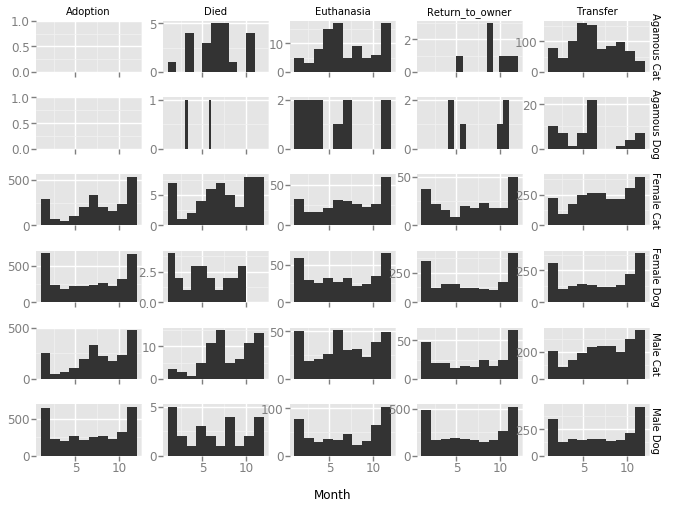

<ggplot: (8733087181509)>

In [38]:
mon_avg_outcomes = pd.concat([g[['Month', 'OutcomeType']]\
 .assign(Group = lambda x: '%s %s' % (['Male', 'Female', 'Agamous'][f[1]], f[0]))
 for f, g in X.groupby(['AnimalType', 'SexuponOutcome'])],
          axis=0)
display(mon_avg_outcomes.head())
display(ggplot(aes(x='Month'), mon_avg_outcomes) +
    geom_histogram() +
    facet_grid('Group', 'OutcomeType', scales='free_y'))

In [40]:
mon_grouper = pd.Grouper(key='DateTime', freq='M')
mon_outcomes = pd.concat([g[['OutcomeType']]\
 .assign(DateTime=f[-1])\
 .assign(Group = lambda x: '%s %s' % (['Male', 'Female', 'Agamous'][f[1]], f[0]))
 for f, g in X.groupby(['AnimalType', 'SexuponOutcome', mon_grouper])],
          axis=0)

display(mon_outcomes.head())

,OutcomeType,DateTime,Group
187,Transfer,2013-10-31,Male Cat
219,Transfer,2013-10-31,Male Cat
285,Return_to_owner,2013-10-31,Male Cat
521,Adoption,2013-10-31,Male Cat
535,Adoption,2013-10-31,Male Cat


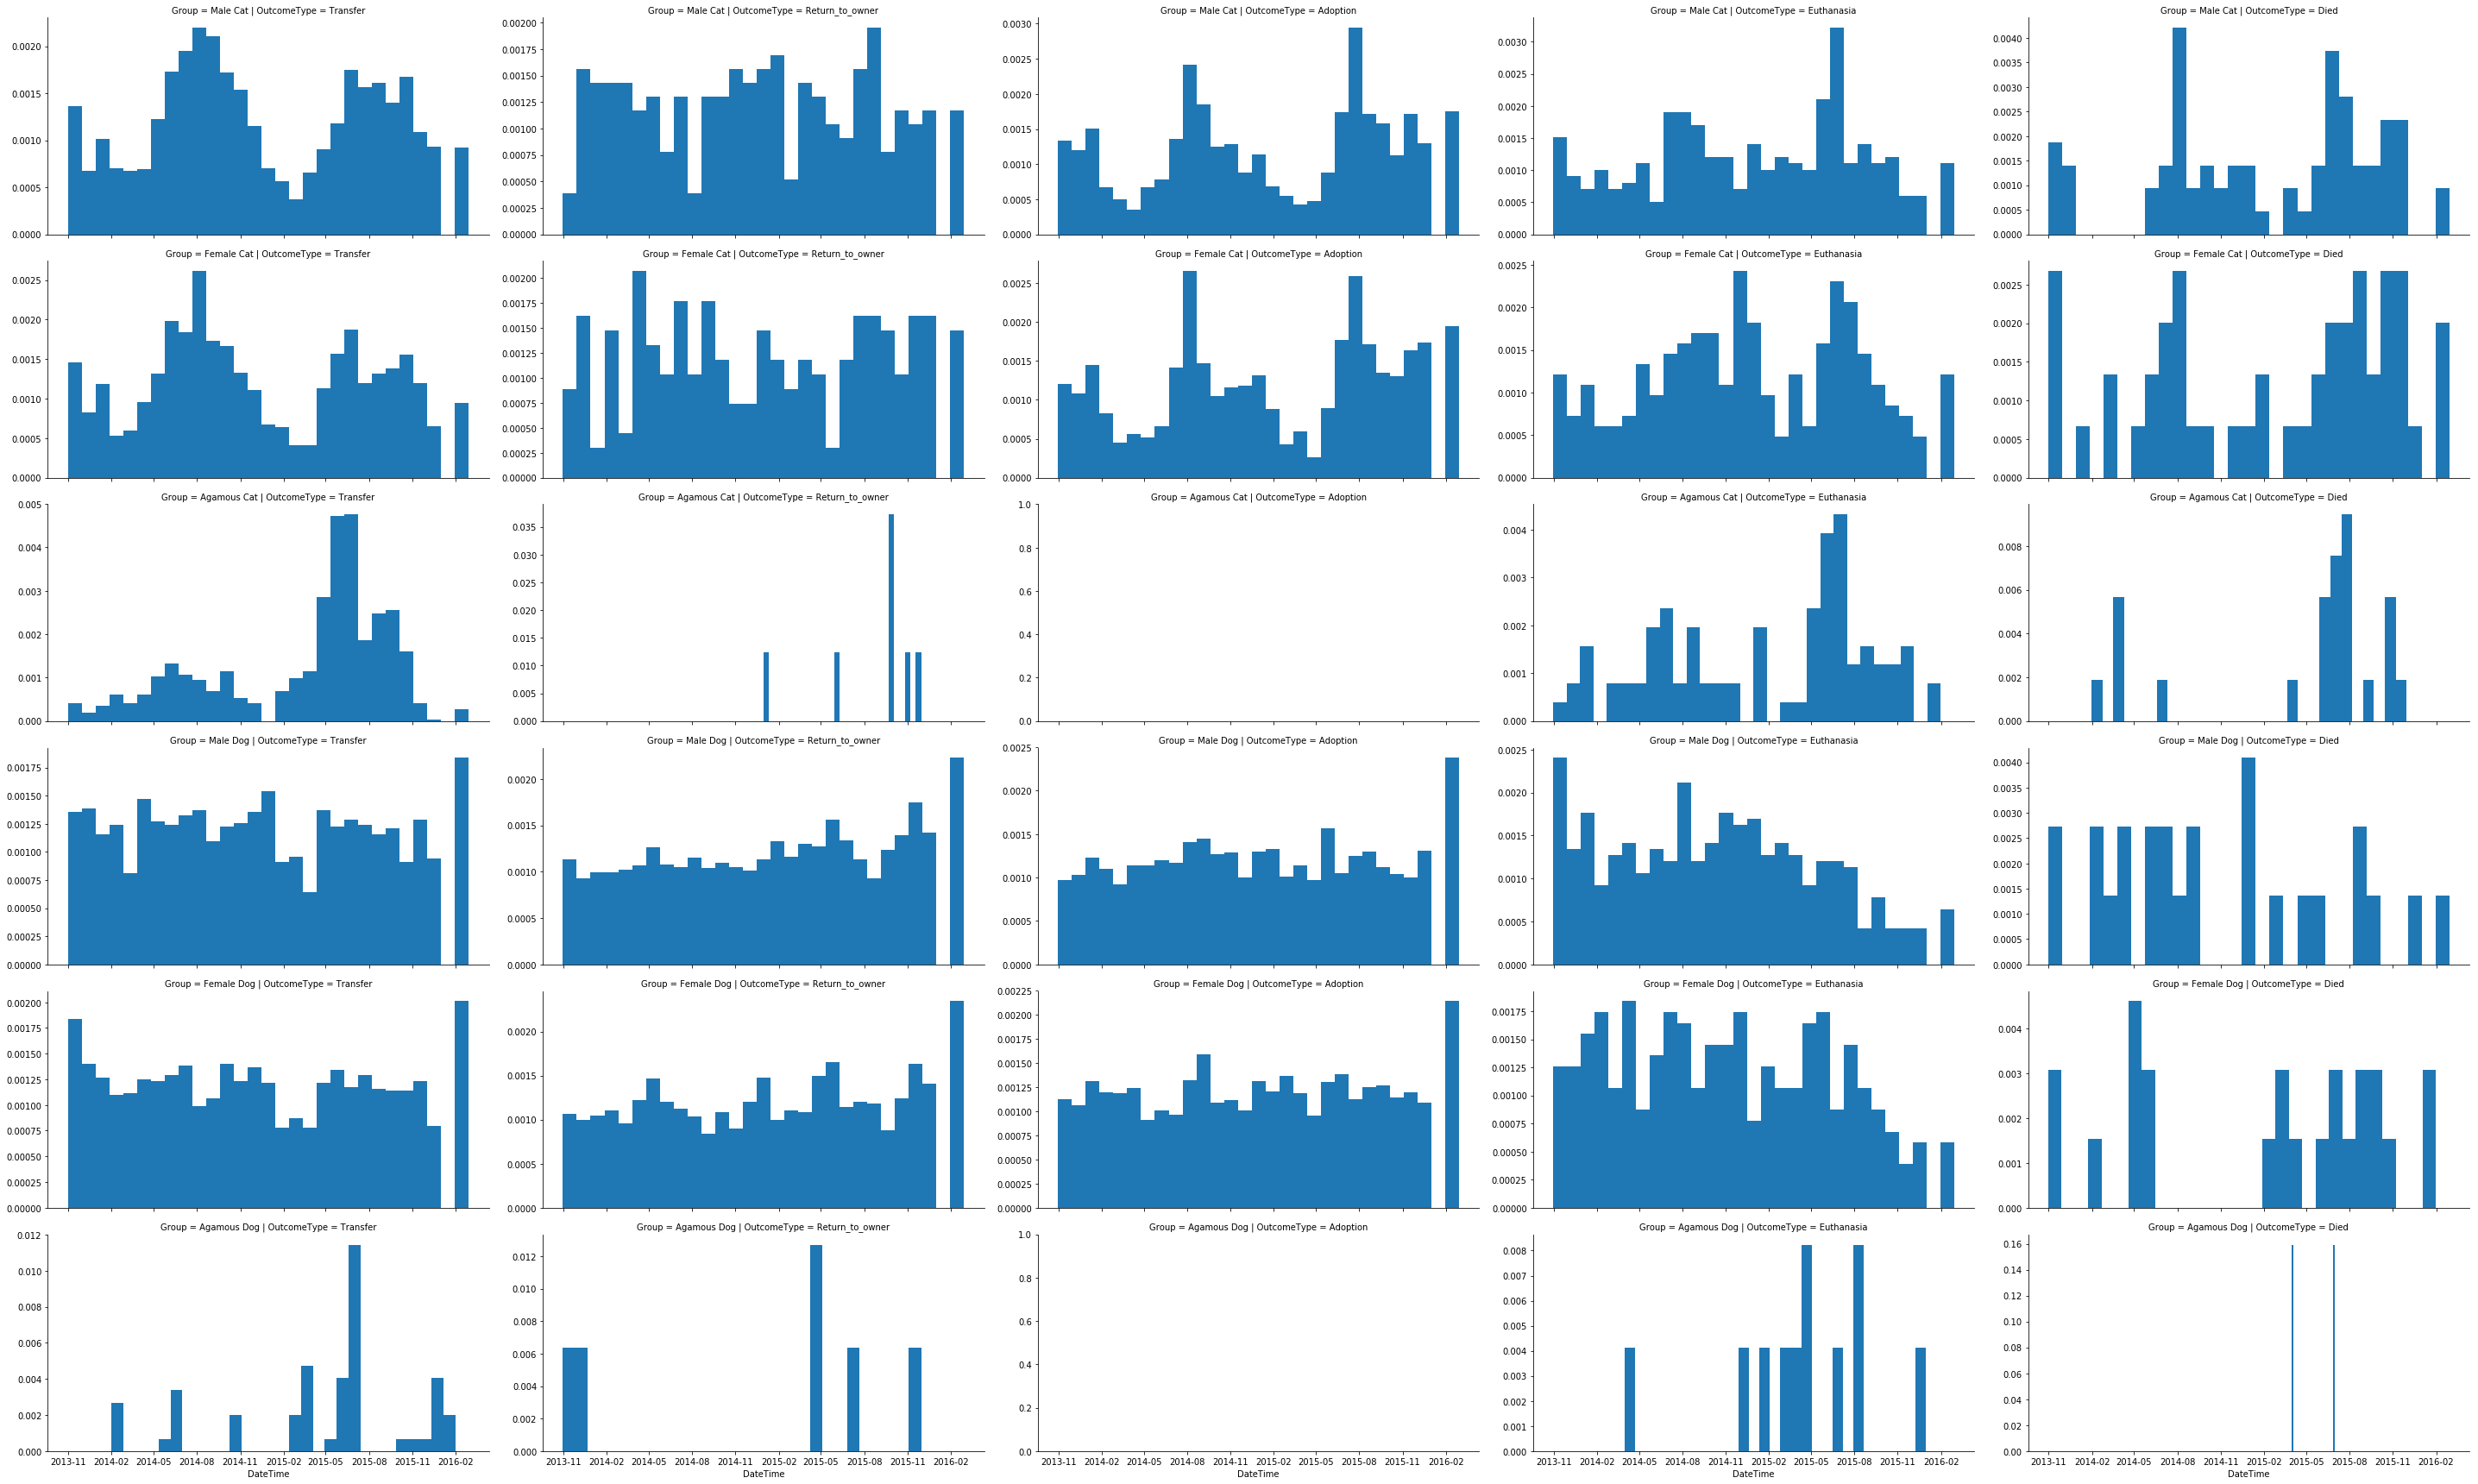

In [41]:
mon_outcomes_fg = sns.FacetGrid(mon_outcomes,
                                row='Group',
                                col='OutcomeType',
                                sharey=False,
                                size=4,
                                aspect=2)
mon_outcomes_fg.map(plt.hist, 'DateTime', normed=True, bins=mon_outcomes['DateTime'].unique().size)

In [18]:
applied_transforms.append(lambda df: df.drop('DateTime', axis=1, inplace=True))
applied_transforms[-1](X)

In [19]:
def simplify_mixed_breeds(df):
    df['Breed'] = df['Breed'].str.replace(re.compile('([^/]+)/?.*'), '\\1')
    return df
applied_transforms.append(simplify_mixed_breeds)
X = simplify_mixed_breeds(X)

                                      25338
Domestic Shorthair                      143
Chihuahua Shorthair                      85
German Shepherd                          77
Labrador Retriever                       69
Pit Bull                                 66
Shih Tzu                                 53
Dachshund                                46
Domestic Medium Hair                     42
Rottweiler                               39
Siberian Husky                           30
Boxer                                    30
Australian Cattle Dog                    25
Pug                                      25
Yorkshire Terrier                        24
Siamese                                  24
Domestic Longhair                        23
Beagle                                   22
Miniature Schnauzer                      22
Miniature Poodle                         21
Cocker Spaniel                           20
Maltese                                  19
Border Collie                   

1391

140

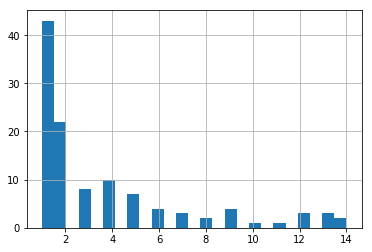

In [20]:
breed_cnts = (X.Breed * (1-X.Mix)).value_counts()
display(breed_cnts, (1-X.Mix).sum())
display(breed_cnts[breed_cnts < 15].hist(bins=25))
display(breed_cnts.size)

In [21]:
clrs_cnts = pd.concat((X.Color, X_te.Color)).value_counts()
clrs_cnts[clrs_cnts < 25].hist(cumulative=True, bins=25)
clrs_cnts

NameError: name 'X_te' is not defined

In [ ]:
test = pd.read_csv('test.csv')
X_te = purify_1(test)
X_te.head()

In [ ]:
test.isnull().sum()

In [ ]:
X_te.loc[X_te['AgeuponOutcome'].isnull()]

In [ ]:
X.loc[X['Breed'] == 'Domestic Shorthair', ['AgeuponOutcome', 'Mix']].groupby(['Mix']).describe()

In [ ]:
X.loc[X['Breed'] == 'Domestic Longhair', ['AgeuponOutcome', 'SexuponOutcome', 'Mix']].groupby(['SexuponOutcome', 'Mix']).describe()

In [ ]:
for T in applied_transforms[1:]:
    X_te = T(X_te)

In [ ]:
display(X.head(), X_te.head())

In [ ]:
X.columns

In [ ]:

X = pd.concat((train.DateTime.apply(transform_date), X))